In [2]:
import numpy as np
import sys
import os 
import tensorflow_model_optimization as tfmt 
import tensorflow as tf
import seaborn as sns
import random
import zipfile
import matplotlib.pyplot as plt

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout
from tensorflow.keras.models import  Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras import layers

from PIL import Image
from PIL import UnidentifiedImageError

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

from tqdm import tqdm 
from collections import Counter

2025-02-09 18:20:10.806517: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739143210.824699  191723 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739143210.830535  191723 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-09 18:20:10.850032: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
print("GPU: ", tf.config.list_physical_devices('GPU'))

GPU:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
#Se extrae el archivo zip
with zipfile.ZipFile("/home/pibezx/Documents/CNN/pokemon.zip", 'r') as zip:
    zip.extractall("Pokemos")

In [5]:
#Se definie el directorio para extraer
datasetDir = "Pokemos/PokemonData"

In [6]:
#PREPROCESAMIENTO DEL DATASET
IMG_SIZE = (224,224)
BATCH_SIZE = 32 

#Lista imagenes del archivo extraido 
image_files = []
labels = []
for root, _, files in os.walk(datasetDir):
    for file in files:
        if file.lower().endswith(('jpeg','jpg','png')):
            image_files.append(os.path.join(root, file))
            labels.append(os.path.basename(root))
        
#Se convierte a tensores (facilidad con tensorflow)
image_files = tf.constant(image_files)
labels = tf.constant(labels)

#Codificar etiquetas para valores int
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels.numpy())

#Convertir etiquetas a tensor
labels = tf.constant(labels)

#Crear dataset de tensorflow 
def parse_function(filename, label):
    img = tf.io.read_file(filename) #lee archivo 
    img = tf.image.decode_jpeg(img, channels=3) #decodifica la imagen
    img = tf.image.resize(img, IMG_SIZE) #redimensiona imagen
    img = img / 255.0 #normalizar los pixeles 0 y 1
    return img, label

dataset = tf.data.Dataset.from_tensor_slices((image_files, labels))
dataset = dataset.map(parse_function, num_parallel_calls=tf.data.AUTOTUNE)

print(f"Numero de imagenes cargadas: {len(image_files)}")
print(f"Numero de etiquetas cargas: {len(labels)}")

Numero de imagenes cargadas: 11945
Numero de etiquetas cargas: 11945


I0000 00:00:1739143219.594148  191723 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3369 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:0b:00.0, compute capability: 7.5


In [7]:
#DIVISION DEL DATASET
print("Se divide el dataset en conjuntos de entrenamiento, validacion y prueba")

dataset = dataset.shuffle(len(image_files), reshuffle_each_iteration=False)
dataset_size = tf.data.experimental.cardinality(dataset).numpy()
print(f"Numero total de imagenes del dataset: {dataset_size}")

train_size = int(0.7 * len(image_files))
val_size = int(0.2 * len(image_files))
test_size = dataset_size - train_size - val_size

print(f"Tamaño del conjunto de Entrenamiento: {train_size}")
print(f"Tamaño del conjunto de Validación: {val_size}")
print(f"Tamaño del conjunto de Prueba: {test_size}")

train_dataset = dataset.take(train_size)
val_test_dataset = dataset.skip(train_size)
val_dataset = dataset.take(val_size)
test_dataset = dataset.skip(val_size)

train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)


print(f"Tamaño del conjunto de Entrenamiento (número de lotes): {tf.data.experimental.cardinality(train_dataset).numpy()}")
print(f"Tamaño del conjunto de Validación (número de lotes): {tf.data.experimental.cardinality(val_dataset).numpy()}")
print(f"Tamaño del conjunto de Prueba (número de lotes): {tf.data.experimental.cardinality(test_dataset).numpy()}")

Se divide el dataset en conjuntos de entrenamiento, validacion y prueba
Numero total de imagenes del dataset: 11945
Tamaño del conjunto de Entrenamiento: 8361
Tamaño del conjunto de Validación: 2389
Tamaño del conjunto de Prueba: 1195
Tamaño del conjunto de Entrenamiento (número de lotes): 262
Tamaño del conjunto de Validación (número de lotes): 75
Tamaño del conjunto de Prueba (número de lotes): 299


In [8]:
#ENTRENAMIENTO DEL MODELO
print("Configurar el modelo MOBILENETV2")
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False,input_shape=(224,224,3))

Configurar el modelo MOBILENETV2


In [ ]:
#ENTRENAMIENTO POR EPOCAS

base_model.trainable = False

inputs = base_model.input
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(len(labels), activation='softmax')(x)


model = tf.keras.Model(inputs=inputs, outputs=outputs)

epochs = 40
steps_per_epoch = np.ceil(train_size / BATCH_SIZE)


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

#model.summary()

callbacks = [
    tfmt.sparsity.keras.UpdatePruningStep(),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
]

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    ]
)


Epoch 1/40


I0000 00:00:1739143233.054086  220170 service.cc:148] XLA service 0x75f048002940 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739143233.054117  220170 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2025-02-09 18:20:33.126008: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1739143233.585691  220170 cuda_dnn.cc:529] Loaded cuDNN version 90700


  5/262 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.0000e+00 - loss: 9.3818   

I0000 00:00:1739143238.064117  220170 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


262/262 ━━━━━━━━━━━━━━━━━━━━ 46s 111ms/step - accuracy: 0.0107 - loss: 7.6022 - val_accuracy: 0.0377 - val_loss: 4.8880
Epoch 2/40
262/262 ━━━━━━━━━━━━━━━━━━━━ 26s 71ms/step - accuracy: 0.0511 - loss: 4.8186 - val_accuracy: 0.1210 - val_loss: 4.5677
Epoch 3/40
262/262 ━━━━━━━━━━━━━━━━━━━━ 27s 70ms/step - accuracy: 0.1271 - loss: 4.4727 - val_accuracy: 0.2118 - val_loss: 4.1746
Epoch 4/40
262/262 ━━━━━━━━━━━━━━━━━━━━ 27s 71ms/step - accuracy: 0.2121 - loss: 4.0730 - val_accuracy: 0.2968 - val_loss: 3.7747
Epoch 5/40
262/262 ━━━━━━━━━━━━━━━━━━━━ 27s 70ms/step - accuracy: 0.3097 - loss: 3.6766 - val_accuracy: 0.3608 - val_loss: 3.3933
Epoch 6/40
262/262 ━━━━━━━━━━━━━━━━━━━━ 27s 71ms/step - accuracy: 0.3825 - loss: 3.3023 - val_accuracy: 0.4261 - val_loss: 3.0427
Epoch 7/40
262/262 ━━━━━━━━━━━━━━━━━━━━ 26s 70ms/step - accuracy: 0.4480 - loss: 2.9609 - val_accuracy: 0.4763 - val_loss: 2.7306
Epoch 8/40
262/262 ━━━━━━━━━━━━━━━━━━━━ 26s 68ms/step - accuracy: 0.5050 - loss: 2.6589 - val_accura

In [9]:
#Evaluar 
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Precision del conjunto de prueba: {test_accuracy * 100:.2f}")

299/299 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - accuracy: 0.9103 - loss: 0.4590
Precision del conjunto de prueba: 85.24


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━

2025-02-09 15:14:06.191183: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


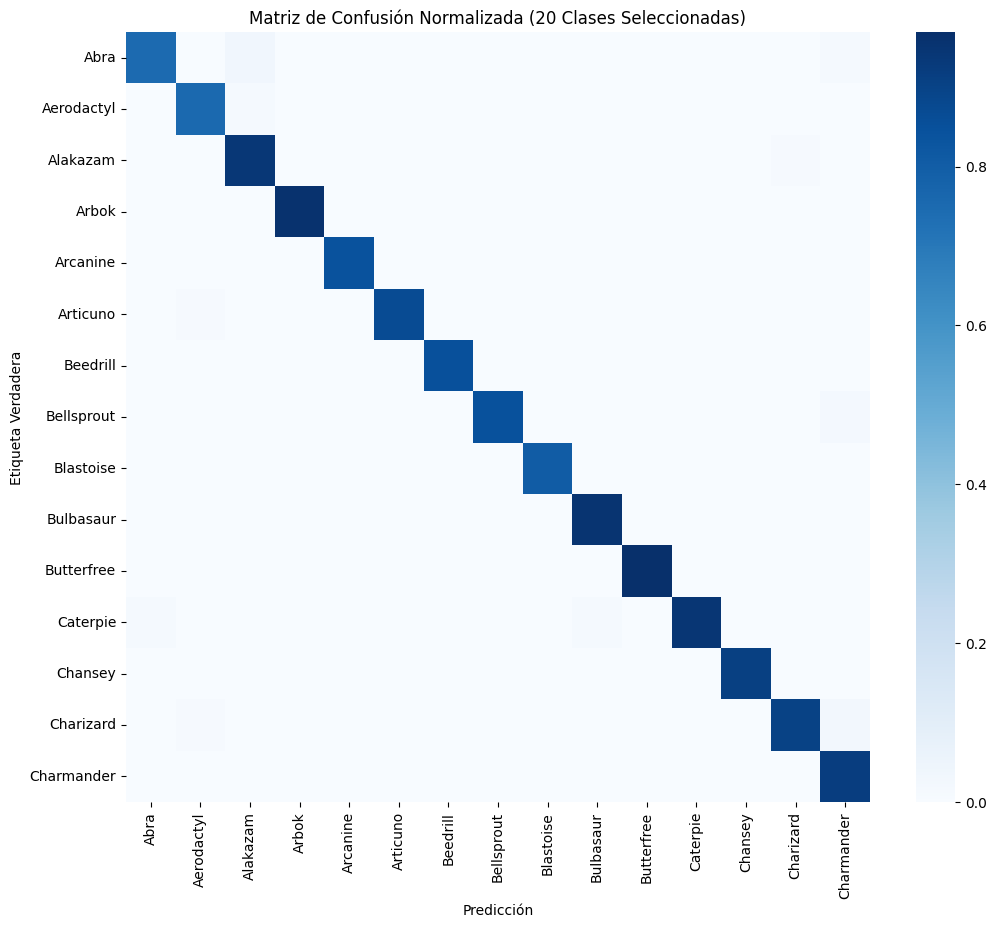

Reporte de Clasificación para las Clases Seleccionadas:

              precision    recall  f1-score   support

        Abra       0.76      0.75      0.76        56
  Aerodactyl       0.86      0.75      0.80        57
    Alakazam       0.73      0.94      0.82        84
       Arbok       0.89      0.96      0.92        73
    Arcanine       0.90      0.84      0.87        51
    Articuno       0.97      0.87      0.92        69
    Beedrill       0.85      0.85      0.85        40
  Bellsprout       0.85      0.85      0.85        52
   Blastoise       0.93      0.80      0.86        46
   Bulbasaur       0.87      0.95      0.91        42
  Butterfree       0.94      0.97      0.95        65
    Caterpie       0.91      0.94      0.93        54
     Chansey       0.97      0.91      0.94        67
   Charizard       0.78      0.90      0.84        71
  Charmander       0.79      0.92      0.85        86

   micro avg       0.85      0.89      0.87       913
   macro avg       0.87

In [10]:
y_true = []
y_pred = []

for images, labels in test_dataset:
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(predicted_labels)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Obtener los nombres de las clases y decodificarlos si es necesario
class_names = label_encoder.classes_
class_names = [name.decode('utf-8') if isinstance(name, bytes) else name for name in class_names]

#Numero maximo para ver en la confusion
max_classes = 15
clases_mostrar = np.arange(max_classes)

# Obtener los nombres de las clases de la lista
class_names_mostrar = [class_names[i] for i in clases_mostrar]


# Normalizar la matriz de confusión completa
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Extraer la submatriz para las clases seleccionadas
cm_mostrar = cm_norm[np.ix_(clases_mostrar, clases_mostrar)]

# Visualizar la matriz de confusión normalizada para las clases seleccionadas
plt.figure(figsize=(12, 10))
sns.heatmap(cm_mostrar, annot=False, cmap='Blues', xticklabels=class_names_mostrar, yticklabels=class_names_mostrar)
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Verdadera')
plt.title('Matriz de Confusión Normalizada (20 Clases Seleccionadas)')
plt.show()

# Generar el reporte de clasificación para las clases seleccionadas
report = classification_report(
    y_true, 
    y_pred, 
    labels=clases_mostrar, 
    target_names=class_names_mostrar
)

print("Reporte de Clasificación para las Clases Seleccionadas:\n")
print(report)

In [ ]:
def mostrar_predicciones_en_prueba(dataset, num_images=6):
    # Crear un iterador del dataset
    dataset_iter = iter(dataset.unbatch().shuffle(1000))

    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        # Obtener la imagen y la etiqueta verdadera
        image, label = next(dataset_iter)
        # Expandir dimensiones para predecir
        image_expanded = tf.expand_dims(image, axis=0)
        # Hacer la predicción
        pred_probs = model.predict(image_expanded)
        pred_label = np.argmax(pred_probs, axis=1)[0]
        # Obtener los nombres de las clases
        true_class_name = label_encoder.inverse_transform([label.numpy()])[0]
        pred_class_name = label_encoder.inverse_transform([pred_label])[0]
        # Mostrar la imagen con las etiquetas
        plt.subplot(2, 3, i+1)
        plt.imshow(image)
        plt.title(f'Verdadero: {true_class_name}\nPredicción: {pred_class_name}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
# Mostrar predicciones en imágenes del conjunto de prueba
mostrar_predicciones_en_prueba(test_dataset)

NameError: name 'test_dataset' is not defined

In [12]:
def cargar_y_preprocesar_imagen(ruta_imagen, img_size=(224, 224)):
    """
    Carga una imagen desde ruta_imagen, la decodifica, la redimensiona
    y la normaliza a [0.0, 1.0].
    Devuelve un tf.Tensor con la forma (224, 224, 3).
    """
    # 1. Leer la imagen en binario
    img = tf.io.read_file(ruta_imagen)

    # 2. Decodificar la imagen (asumiendo JPG/PNG con 3 canales)
    img = tf.image.decode_jpeg(img, channels=3)

    # 3. Redimensionar la imagen
    img = tf.image.resize(img, img_size)

    # 4. Normalizar la imagen [0,1]
    img = img / 255.0

    return img

In [13]:
def predecir_varias_imagenes(rutas_imagenes):
    imgs = []
    for ruta_imagen in rutas_imagenes:
        img = cargar_y_preprocesar_imagen(ruta_imagen)
        imgs.append(img)
    # Crear un batch de imágenes
    imgs_batch = tf.stack(imgs, axis=0)
    # Hacer las predicciones
    pred_probs = model.predict(imgs_batch)
    pred_labels = np.argmax(pred_probs, axis=1)
    pred_class_names = label_encoder.inverse_transform(pred_labels)
    # Mostrar las imágenes con sus predicciones
    plt.figure(figsize=(15, 10))
    for i in range(len(rutas_imagenes)):
        plt.subplot(2, 3, i+1)
        plt.imshow(imgs[i])
        plt.title(f'Predicción: {pred_class_names[i]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    # Imprimir las predicciones
    for i, ruta_imagen in enumerate(rutas_imagenes):
        print(f'Imagen: {ruta_imagen} - Predicción: {pred_class_names[i]}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


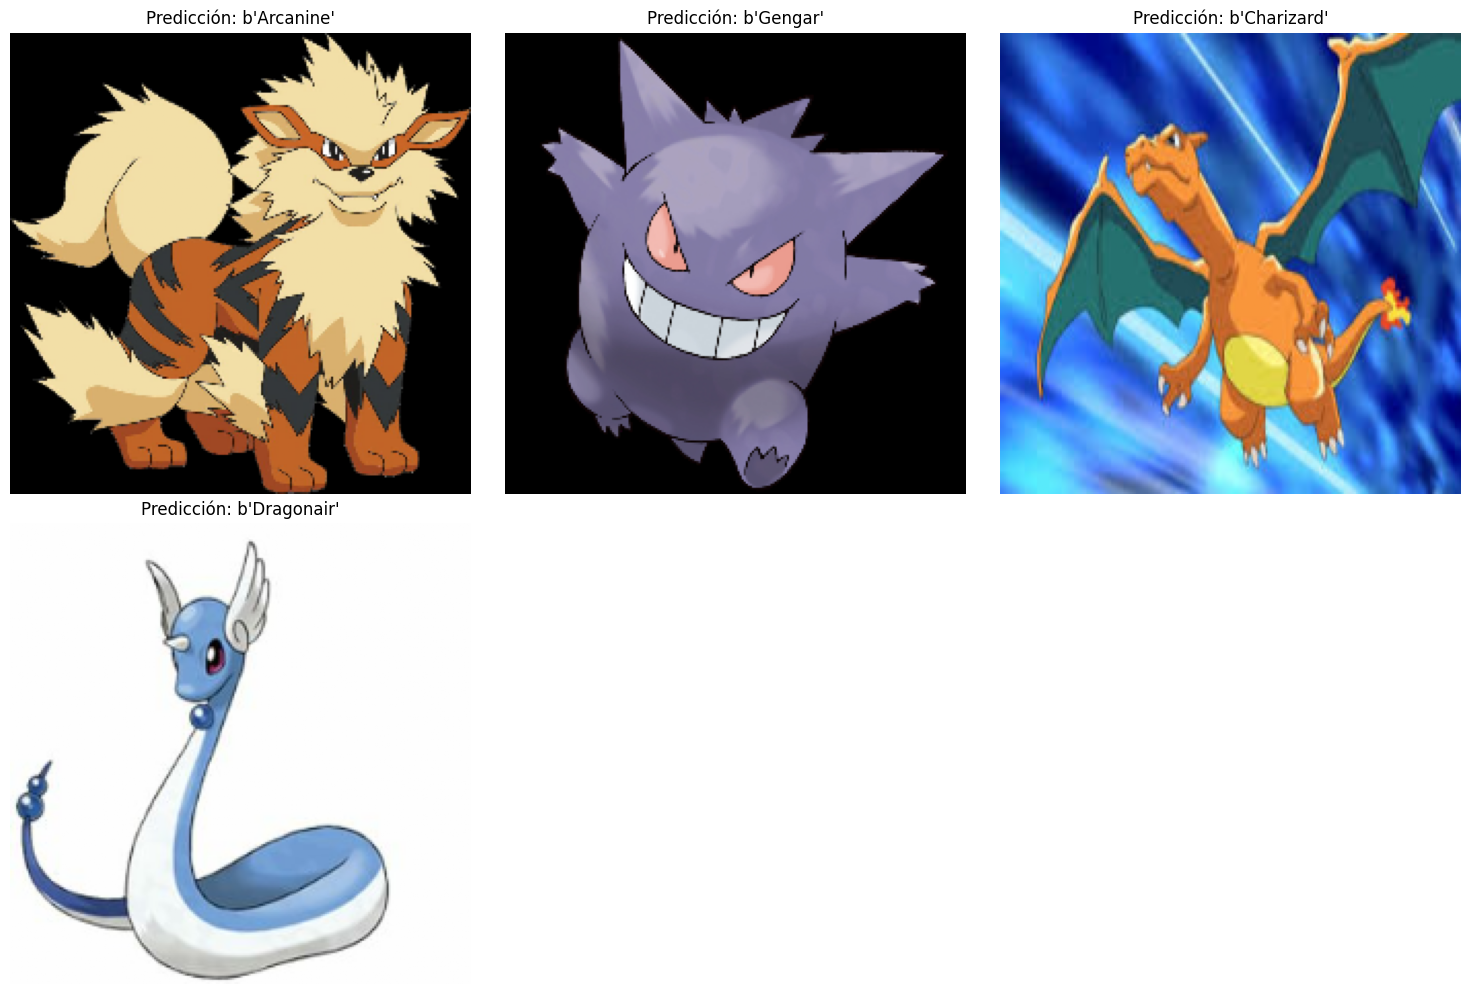

Imagen: PokemonTest/14564190248867.png - Predicción: b'Arcanine'
Imagen: PokemonTest/800px-Gengar.png - Predicción: b'Gengar'
Imagen: PokemonTest/images.jpg - Predicción: b'Charizard'
Imagen: PokemonTest/1.jpg - Predicción: b'Dragonair'


In [14]:

rutas_imagenes = [
    'PokemonTest/14564190248867.png',
    'PokemonTest/800px-Gengar.png',
    'PokemonTest/images.jpg',
    'PokemonTest/1.jpg',
]

predecir_varias_imagenes(rutas_imagenes)